In [1]:
#functions

import math
import random


# makes a ticket
def ticket_generator(t, o, a):
    ticket={
        'time': t,
        'owner': o,
        'action': a,
    }
    return ticket;


# depending on parameter (spread or cure), generates tau
def nextTime(rateParameter, n):
    taus=[0]*n
    for i in range(0,n): #start at zero, stops just short of n
        taus[i]=random.expovariate(rateParameter)#e**(-rateParameter*random.random())#-math.log(1.0 - random.random()) / rateParameter #math.log is in base e, and random.random picks a number from range 0.0 to 1.
    return taus #generates n-length list, starting at index 0


#writes the edges to a network of n ppl where everyone is connected to everyone else 
def network_writer(n):
    connect=[0]*n
    for i in range(0, n): 
        a=list(range(n)) #generating a list that goes from 0 to n-1
        a.remove(i) #individual removes themselves from the network
        connect[i]=a #corresponds to the list of people person i is linked to
    return connect; #returns a list of lists with all the connections in the network

#Checks the proportion of agents in infected state at regular intervals
def timechecktickethandler(prop_inf, ppl_state, num_ppl, check_acc):
    prop_inf[check_acc]=sum(ppl_state)/num_ppl


#ONCE NETWORKS ARE NOT SMALL WORLD, WILL NEED TO PASS IN CONNECT TO FUNCTION TO SEE WHO CAN BE INFECTED BY THE OWNER 
#(ow) AND TO GENERATE THE CORRECT LENGTH FOR Ts

#processes spread/infection tickets, returning a new timeline (with added tickets) and an updated list of states
def spreadtickethandler(tic, timeline, spreadparam, cureparam, ppl_state, t_max): 
    ow=tic['owner']
    targ=tic['action'] #this action should not be -1 bc this is passed to spread ticket handler
    if (ow==targ):
        print('Error -- ow=targ, {:d}={:d}' .format(ow,targ)) 

#The spreadtickethandler function is broken into 4 steps, as outlined in appendix B.1.2 of 
#Ruud VAN DE BOVENKAMP's thesis (p. 158)
        
#1
    if(ppl_state[ow]!=1):
        print('Error -- individual {:d} is not infected, but was passed to spreadtickethandler!' .format(ow))
    else:
#2
        t=tic['time']
        if(ppl_state[targ]==1):
            print('{:d} is already infected! at time {:f}' .format(targ,t)) 
        else:
            ppl_state[targ]=1 #Set targ to be infected
            num_ppl=len(ppl_state) #number of people
            ts=[t]*(num_ppl-1) #list of t repeated num_ppl-1 times
            nT=nextTime(spreadparam, num_ppl-1) #generates taus
            cure_t=t+nextTime(cureparam, 1)[0] #using [0] in order to add an integer to t
            spread_ts=[sum(x) for x in zip(ts,nT)] 
            acc=0 #accumulator initialized
            for a in connect[targ]: #Go through all of targ's connections and create spread tickets as necessary
                if(spread_ts[acc]<cure_t and spread_ts[acc]<t_max): #if the spread time occurs before targ is cured and does not exceed t_max
                    tinf=ticket_generator(spread_ts[acc], targ, a) #generate spread ticket
                    add_to_timeline(tinf, timeline) #add spread ticket to timeline
                acc=acc+1 #accumulator incremented
            if cure_t<t_max: #if the cure time doesn't exceed t_max
                tcure=ticket_generator(cure_t, targ, -1) #generate cure ticket
                add_to_timeline(tcure, timeline) #add cure ticket to timeline
#3
        #in our code, timechecktickethandler checks the infected count at certain time intervals
#4
        spread_t2=t+nextTime(spreadparam,1)[0] #spread_t2 is the time for respreading from ow to targ
        cure_t_ow=t_max+1 #just so we don't get an error on line 91 if cure_t_ow isn't generated in the while loop bc it's too big
        i=timeholder #timeholder is index of timeline
        curefound=0 #a flag for the while loop
        #looking for the curetime of each individual
        while curefound==0 and i<(len(timeline)-1): #while cure is not found and we aren't beyond last index of timeline
            tim=timeline[i]
            if(tim['owner']==ow): 
                if(tim['action']==-1): #-1 is action associated with cure tickets
                    cure_t_ow=tim['time'] #set cure time of owner
                    curefound=1 #stop when cure is found
            i=i+1 
        if(spread_t2<cure_t_ow and spread_t2<t_max): #if re-infection spread time is less cure time of owner and doesn't exceed t_max
            spread2tic=ticket_generator(spread_t2, ow, targ) #make a spread ticket for re-infection of targ by ow
            add_to_timeline(spread2tic, timeline) #add spread ticket to timeline
        return [timeline, ppl_state];
            
        
    
#processes cure tickets, returning the new states of ppl        
def curetickethandler(tic, ppl_state):
    ow=tic['owner']
    ppl_state[ow]=0
    return ppl_state

#adds new tickets to timeline -- Stefano, any more efficient suggestions for keeping timeline in order?
def add_to_timeline(tic, tim):
    if not tim:
        return [tic]
    ind=len(tim)-1
    end=0
    while (tic['time']<tim[ind]['time'] and end==0): #moves backwards until it finds where to place the ticket based on the listed times
        ind=ind-1 
        if(ind<0):
            end=1
    ind=ind+1
    tim.insert(ind, tic)
    return tim

#adjusts ind so times can match with nodes correctly (accounts for the fact that in connections, owner is omitted)
def new_ind(ind, ow):
    if(ind>ow):
        ind=ind-1
    return ind

In [2]:
#NOTE: be able to start w whatever # of sick ppl we want
#main -- uses functions described above to simulate SIS dynamics over time using agent based model
random.seed(4)
t_max=6 #we want to go to 2 time units (trust us, it still takes a while)
sick_ind=0 #we will set individual 0 to start out sick, but could also use random number generator
spreadparam=.05 
cureparam=3
#curetimearray=[]; #DELETE!!!
timeline=[] #initialize empty timeline
num_ppl=400 #set # of agents
ppl_state=[0]*num_ppl #make a record of everyone's state, starting with all succeptible except...
ppl_state[sick_ind]=1 #starting with 1 infected person, sick_ind
connect=network_writer(num_ppl) #make a network of connections btwn the ppl -- everyone is connected to everyone rn
tinfinit=nextTime(spreadparam, num_ppl-1) #generate the time of the first infection THIS IS NOW ALL THE TIMES -- one for each
tcureinit=nextTime(cureparam, 1)[0] #generate the time of sick_ind's cure
while(all(i < tcureinit for i in tinfinit)): #for the very rare case that no individuals get infected before individual 0 gets cured
    tcureinit=nextTime(cureparam,1) #ensure that that time occurs after patient 0 has infected someone -- just so our sim goes somewhere

smallinds=[] #isolate only those times that are smaller than cure time  
acc=0
for i in connect[sick_ind]:        
    if tinfinit[acc]<tcureinit:
        smallinds.append(i)
    acc=acc+1  
for i in range (len(smallinds)):
    init_inf=ticket_generator(tinfinit[new_ind(smallinds[i], sick_ind)], sick_ind, smallinds[i])#generate a ticket for the first infection 
    timeline=add_to_timeline(init_inf, timeline) #put these 2 tickets on timeline
#we will probably change the above 9 lines to be like what we do in spreadtickethandler, which is more intuitive


init_cure=ticket_generator(tcureinit, sick_ind, -1) # generate a ticket for the first cure
timeline=add_to_timeline(init_cure, timeline) #add it to timeline
l=list(range(0, (t_max)*100, 1))
l2=[.01]*len(l)
check_times=[a*b for a,b in zip(l,l2)] #our list goes from 0 to tmax with intervals of .1
for i in check_times:
    tchecktic=ticket_generator(i, -2, -2) #-2 here indicates that this is a time-check ticket
    add_to_timeline(tchecktic, timeline) #add to timeline
prop_inf=[0]*len(check_times) #initialize proportion infected storage vector
timeholder=0 #timeholder is the index where we are on the timeline (start at 0)
t=0 #we start at a time of 0 
check_acc=0 #accumulator to help us index prop_inf



In [3]:
#main ct'd

while t<t_max:
    #print(t)
    if timeholder>(len(timeline)-1): #if timeholder exceeds max timeline index
        #print(sum(ppl_state)/num_ppl)
        print('end')
        break
    nexttic=timeline[timeholder] #look at the ticket corresponding to where we are on the timeline
    if (nexttic['action']==-1): #if it's a cure ticket, use the corresponding handler
        ppl_state=curetickethandler(nexttic, ppl_state) #handler returns ppl_state
    elif nexttic['action']==-2: #if it's a time check ticket use the corresponding handler
        timechecktickethandler(prop_inf, ppl_state, num_ppl, check_acc) #fills in prop_inf
        check_acc=check_acc+1 #increment accumulator
    else: #if it's a spread ticket, use the corresponding handler
        vec=spreadtickethandler(nexttic, timeline, spreadparam, cureparam, ppl_state, t_max)
        timeline=vec[0] #returns updated timeline
        ppl_state=vec[1] #and updated ppl_state
    t=nexttic['time'] #new time based on the ticket we just read

    
    timeholder=timeholder+1 #increment timeholder
    


33 is already infected! at time 0.187874
259 is already infected! at time 0.189467
82 is already infected! at time 0.196038
144 is already infected! at time 0.203809
337 is already infected! at time 0.236931
247 is already infected! at time 0.239113
106 is already infected! at time 0.243882
109 is already infected! at time 0.255338
375 is already infected! at time 0.258768
134 is already infected! at time 0.263735
97 is already infected! at time 0.264424
102 is already infected! at time 0.264838
236 is already infected! at time 0.265261
172 is already infected! at time 0.267820
215 is already infected! at time 0.268987
325 is already infected! at time 0.272030
5 is already infected! at time 0.272399
375 is already infected! at time 0.272718
361 is already infected! at time 0.274291
223 is already infected! at time 0.276457
80 is already infected! at time 0.276722
34 is already infected! at time 0.277832
252 is already infected! at time 0.278696
163 is already infected! at time 0.283847

355 is already infected! at time 0.397832
313 is already infected! at time 0.398240
301 is already infected! at time 0.398626
220 is already infected! at time 0.398936
174 is already infected! at time 0.399385
31 is already infected! at time 0.400029
155 is already infected! at time 0.400508
2 is already infected! at time 0.400660
124 is already infected! at time 0.400981
313 is already infected! at time 0.400993
51 is already infected! at time 0.401180
268 is already infected! at time 0.401537
319 is already infected! at time 0.401814
201 is already infected! at time 0.401936
224 is already infected! at time 0.402174
74 is already infected! at time 0.402255
162 is already infected! at time 0.402411
359 is already infected! at time 0.402521
90 is already infected! at time 0.402598
290 is already infected! at time 0.402739
333 is already infected! at time 0.402798
86 is already infected! at time 0.402805
185 is already infected! at time 0.403223
193 is already infected! at time 0.403806

287 is already infected! at time 0.472912
102 is already infected! at time 0.472943
344 is already infected! at time 0.473591
261 is already infected! at time 0.473607
135 is already infected! at time 0.473660
124 is already infected! at time 0.473721
129 is already infected! at time 0.473753
83 is already infected! at time 0.474082
215 is already infected! at time 0.474245
230 is already infected! at time 0.474250
315 is already infected! at time 0.474340
340 is already infected! at time 0.474527
314 is already infected! at time 0.474597
255 is already infected! at time 0.474601
214 is already infected! at time 0.474762
239 is already infected! at time 0.474868
178 is already infected! at time 0.475037
202 is already infected! at time 0.475101
222 is already infected! at time 0.475305
372 is already infected! at time 0.475670
324 is already infected! at time 0.475717
142 is already infected! at time 0.475952
251 is already infected! at time 0.476266
110 is already infected! at time 0.

42 is already infected! at time 0.530046
66 is already infected! at time 0.530680
338 is already infected! at time 0.530713
310 is already infected! at time 0.531170
223 is already infected! at time 0.531715
109 is already infected! at time 0.531831
81 is already infected! at time 0.531984
334 is already infected! at time 0.532063
183 is already infected! at time 0.532138
49 is already infected! at time 0.532194
108 is already infected! at time 0.532378
328 is already infected! at time 0.532832
7 is already infected! at time 0.533121
338 is already infected! at time 0.533441
313 is already infected! at time 0.533443
128 is already infected! at time 0.533592
89 is already infected! at time 0.533685
119 is already infected! at time 0.533921
370 is already infected! at time 0.534106
327 is already infected! at time 0.534610
229 is already infected! at time 0.534669
341 is already infected! at time 0.534807
195 is already infected! at time 0.534960
79 is already infected! at time 0.535000


187 is already infected! at time 0.572375
376 is already infected! at time 0.572517
367 is already infected! at time 0.572783
269 is already infected! at time 0.572908
286 is already infected! at time 0.573002
108 is already infected! at time 0.573161
123 is already infected! at time 0.573296
142 is already infected! at time 0.573503
53 is already infected! at time 0.573531
267 is already infected! at time 0.573537
32 is already infected! at time 0.573616
25 is already infected! at time 0.573714
156 is already infected! at time 0.573716
270 is already infected! at time 0.574111
73 is already infected! at time 0.574268
395 is already infected! at time 0.574312
227 is already infected! at time 0.574713
66 is already infected! at time 0.574771
377 is already infected! at time 0.574963
366 is already infected! at time 0.575297
19 is already infected! at time 0.575455
319 is already infected! at time 0.575562
156 is already infected! at time 0.575899
118 is already infected! at time 0.57595

173 is already infected! at time 0.616258
306 is already infected! at time 0.616654
174 is already infected! at time 0.617180
369 is already infected! at time 0.617384
194 is already infected! at time 0.618504
298 is already infected! at time 0.618535
8 is already infected! at time 0.618627
339 is already infected! at time 0.618732
175 is already infected! at time 0.618746
41 is already infected! at time 0.618764
200 is already infected! at time 0.618842
292 is already infected! at time 0.618951
373 is already infected! at time 0.618951
258 is already infected! at time 0.619146
194 is already infected! at time 0.619548
258 is already infected! at time 0.619636
244 is already infected! at time 0.619694
364 is already infected! at time 0.619695
170 is already infected! at time 0.619803
228 is already infected! at time 0.619868
152 is already infected! at time 0.619871
293 is already infected! at time 0.619992
197 is already infected! at time 0.620041
43 is already infected! at time 0.620

230 is already infected! at time 0.660145
299 is already infected! at time 0.660176
49 is already infected! at time 0.660261
62 is already infected! at time 0.660405
252 is already infected! at time 0.660432
17 is already infected! at time 0.660516
300 is already infected! at time 0.660575
299 is already infected! at time 0.660937
156 is already infected! at time 0.661308
129 is already infected! at time 0.661469
124 is already infected! at time 0.661554
6 is already infected! at time 0.661554
130 is already infected! at time 0.661612
232 is already infected! at time 0.661829
3 is already infected! at time 0.662028
315 is already infected! at time 0.662089
127 is already infected! at time 0.662269
126 is already infected! at time 0.662369
91 is already infected! at time 0.662471
374 is already infected! at time 0.662546
271 is already infected! at time 0.662617
106 is already infected! at time 0.662748
360 is already infected! at time 0.663301
58 is already infected! at time 0.663395
1

77 is already infected! at time 0.704250
140 is already infected! at time 0.704282
164 is already infected! at time 0.704293
100 is already infected! at time 0.704374
118 is already infected! at time 0.704492
11 is already infected! at time 0.704716
385 is already infected! at time 0.704926
93 is already infected! at time 0.705390
370 is already infected! at time 0.705429
196 is already infected! at time 0.705478
35 is already infected! at time 0.705504
235 is already infected! at time 0.705509
102 is already infected! at time 0.705842
51 is already infected! at time 0.705883
392 is already infected! at time 0.706236
327 is already infected! at time 0.706544
255 is already infected! at time 0.706747
209 is already infected! at time 0.706902
18 is already infected! at time 0.706945
161 is already infected! at time 0.707197
365 is already infected! at time 0.707429
338 is already infected! at time 0.707431
208 is already infected! at time 0.707999
98 is already infected! at time 0.708032

93 is already infected! at time 0.754940
306 is already infected! at time 0.755038
343 is already infected! at time 0.755230
46 is already infected! at time 0.755368
92 is already infected! at time 0.755388
19 is already infected! at time 0.755540
32 is already infected! at time 0.755746
259 is already infected! at time 0.755833
318 is already infected! at time 0.755855
42 is already infected! at time 0.755876
243 is already infected! at time 0.755930
77 is already infected! at time 0.755945
326 is already infected! at time 0.756086
284 is already infected! at time 0.756166
340 is already infected! at time 0.756247
124 is already infected! at time 0.756639
257 is already infected! at time 0.757311
361 is already infected! at time 0.757345
56 is already infected! at time 0.757512
245 is already infected! at time 0.757657
163 is already infected! at time 0.757663
308 is already infected! at time 0.757845
169 is already infected! at time 0.757953
279 is already infected! at time 0.758213


257 is already infected! at time 0.812343
50 is already infected! at time 0.812399
168 is already infected! at time 0.812447
212 is already infected! at time 0.812489
261 is already infected! at time 0.812556
14 is already infected! at time 0.813118
265 is already infected! at time 0.813259
40 is already infected! at time 0.813639
22 is already infected! at time 0.814046
247 is already infected! at time 0.814465
323 is already infected! at time 0.814528
42 is already infected! at time 0.814632
199 is already infected! at time 0.814686
373 is already infected! at time 0.814761
380 is already infected! at time 0.815484
380 is already infected! at time 0.815716
100 is already infected! at time 0.815763
359 is already infected! at time 0.815765
223 is already infected! at time 0.815805
241 is already infected! at time 0.815875
337 is already infected! at time 0.815884
210 is already infected! at time 0.815917
237 is already infected! at time 0.816117
149 is already infected! at time 0.8161

169 is already infected! at time 0.849608
148 is already infected! at time 0.849640
88 is already infected! at time 0.849991
2 is already infected! at time 0.850367
135 is already infected! at time 0.850629
56 is already infected! at time 0.850743
350 is already infected! at time 0.850776
107 is already infected! at time 0.850832
338 is already infected! at time 0.851234
116 is already infected! at time 0.851610
390 is already infected! at time 0.851610
355 is already infected! at time 0.851682
113 is already infected! at time 0.851731
61 is already infected! at time 0.852154
127 is already infected! at time 0.852303
22 is already infected! at time 0.852304
330 is already infected! at time 0.852383
81 is already infected! at time 0.852897
16 is already infected! at time 0.853157
284 is already infected! at time 0.853271
125 is already infected! at time 0.853761
392 is already infected! at time 0.853890
206 is already infected! at time 0.853935
150 is already infected! at time 0.853982


122 is already infected! at time 0.888993
359 is already infected! at time 0.889014
30 is already infected! at time 0.889980
305 is already infected! at time 0.890108
240 is already infected! at time 0.890182
202 is already infected! at time 0.890353
63 is already infected! at time 0.890635
165 is already infected! at time 0.890893
205 is already infected! at time 0.890964
203 is already infected! at time 0.890972
240 is already infected! at time 0.890972
375 is already infected! at time 0.891068
125 is already infected! at time 0.891167
70 is already infected! at time 0.891271
322 is already infected! at time 0.891376
118 is already infected! at time 0.891421
74 is already infected! at time 0.891464
248 is already infected! at time 0.891555
10 is already infected! at time 0.891579
44 is already infected! at time 0.891583
360 is already infected! at time 0.891639
386 is already infected! at time 0.891673
76 is already infected! at time 0.891817
136 is already infected! at time 0.892005

310 is already infected! at time 0.934946
219 is already infected! at time 0.934986
81 is already infected! at time 0.934991
20 is already infected! at time 0.935413
47 is already infected! at time 0.935678
54 is already infected! at time 0.935711
171 is already infected! at time 0.935839
31 is already infected! at time 0.935861
199 is already infected! at time 0.936031
27 is already infected! at time 0.936143
354 is already infected! at time 0.936390
143 is already infected! at time 0.936460
279 is already infected! at time 0.936490
354 is already infected! at time 0.936745
6 is already infected! at time 0.936808
9 is already infected! at time 0.936836
122 is already infected! at time 0.936938
360 is already infected! at time 0.937059
93 is already infected! at time 0.937111
53 is already infected! at time 0.937441
241 is already infected! at time 0.937736
44 is already infected! at time 0.937772
277 is already infected! at time 0.937825
339 is already infected! at time 0.937948
370 i

14 is already infected! at time 0.964735
6 is already infected! at time 0.964787
302 is already infected! at time 0.964801
221 is already infected! at time 0.965264
218 is already infected! at time 0.965429
270 is already infected! at time 0.965584
175 is already infected! at time 0.965638
322 is already infected! at time 0.965658
99 is already infected! at time 0.966055
126 is already infected! at time 0.966117
216 is already infected! at time 0.966144
383 is already infected! at time 0.966158
60 is already infected! at time 0.966297
155 is already infected! at time 0.966300
94 is already infected! at time 0.966869
249 is already infected! at time 0.967621
65 is already infected! at time 0.967735
310 is already infected! at time 0.968162
219 is already infected! at time 0.968163
143 is already infected! at time 0.968202
81 is already infected! at time 0.968330
302 is already infected! at time 0.968373
311 is already infected! at time 0.968410
56 is already infected! at time 0.968452
3

278 is already infected! at time 1.025954
20 is already infected! at time 1.025954
52 is already infected! at time 1.026053
79 is already infected! at time 1.026216
182 is already infected! at time 1.026222
178 is already infected! at time 1.026353
50 is already infected! at time 1.026512
162 is already infected! at time 1.026520
17 is already infected! at time 1.026665
246 is already infected! at time 1.026701
156 is already infected! at time 1.026879
248 is already infected! at time 1.027100
168 is already infected! at time 1.027141
33 is already infected! at time 1.027573
324 is already infected! at time 1.027660
74 is already infected! at time 1.027725
286 is already infected! at time 1.028426
235 is already infected! at time 1.028503
1 is already infected! at time 1.028516
317 is already infected! at time 1.028692
97 is already infected! at time 1.028843
320 is already infected! at time 1.028865
239 is already infected! at time 1.029185
328 is already infected! at time 1.029578
28

292 is already infected! at time 1.073227
170 is already infected! at time 1.073337
174 is already infected! at time 1.073446
373 is already infected! at time 1.073570
131 is already infected! at time 1.073616
94 is already infected! at time 1.073826
324 is already infected! at time 1.073992
180 is already infected! at time 1.074063
394 is already infected! at time 1.074077
52 is already infected! at time 1.074162
90 is already infected! at time 1.074276
89 is already infected! at time 1.074336
326 is already infected! at time 1.074350
221 is already infected! at time 1.074442
253 is already infected! at time 1.074562
287 is already infected! at time 1.074638
297 is already infected! at time 1.074931
77 is already infected! at time 1.075053
228 is already infected! at time 1.075186
141 is already infected! at time 1.075425
175 is already infected! at time 1.075796
197 is already infected! at time 1.075891
55 is already infected! at time 1.075941
271 is already infected! at time 1.07598

123 is already infected! at time 1.119346
338 is already infected! at time 1.119349
116 is already infected! at time 1.119416
17 is already infected! at time 1.119459
246 is already infected! at time 1.119469
375 is already infected! at time 1.119862
391 is already infected! at time 1.120143
390 is already infected! at time 1.120262
43 is already infected! at time 1.121177
186 is already infected! at time 1.121206
339 is already infected! at time 1.121219
83 is already infected! at time 1.121365
351 is already infected! at time 1.121442
248 is already infected! at time 1.121668
229 is already infected! at time 1.122155
385 is already infected! at time 1.122228
306 is already infected! at time 1.122423
369 is already infected! at time 1.122451
129 is already infected! at time 1.122470
304 is already infected! at time 1.122494
197 is already infected! at time 1.122593
309 is already infected! at time 1.123150
105 is already infected! at time 1.123266
316 is already infected! at time 1.12

89 is already infected! at time 1.191434
143 is already infected! at time 1.191761
379 is already infected! at time 1.191815
262 is already infected! at time 1.192113
348 is already infected! at time 1.192286
183 is already infected! at time 1.192300
126 is already infected! at time 1.192905
319 is already infected! at time 1.192953
176 is already infected! at time 1.192992
194 is already infected! at time 1.193114
248 is already infected! at time 1.193754
194 is already infected! at time 1.193784
119 is already infected! at time 1.193981
199 is already infected! at time 1.194241
77 is already infected! at time 1.194255
324 is already infected! at time 1.194437
102 is already infected! at time 1.194633
228 is already infected! at time 1.194853
324 is already infected! at time 1.195077
258 is already infected! at time 1.195143
222 is already infected! at time 1.195341
70 is already infected! at time 1.195477
68 is already infected! at time 1.195527
289 is already infected! at time 1.195

264 is already infected! at time 1.278655
190 is already infected! at time 1.279016
331 is already infected! at time 1.279088
306 is already infected! at time 1.279109
237 is already infected! at time 1.279281
318 is already infected! at time 1.279296
272 is already infected! at time 1.279336
386 is already infected! at time 1.279432
313 is already infected! at time 1.279527
36 is already infected! at time 1.279544
132 is already infected! at time 1.279668
161 is already infected! at time 1.279675
6 is already infected! at time 1.280337
46 is already infected! at time 1.280648
397 is already infected! at time 1.281148
236 is already infected! at time 1.281187
97 is already infected! at time 1.281628
326 is already infected! at time 1.281667
247 is already infected! at time 1.281767
345 is already infected! at time 1.281894
6 is already infected! at time 1.282128
299 is already infected! at time 1.282224
110 is already infected! at time 1.282692
394 is already infected! at time 1.282873

58 is already infected! at time 1.384842
291 is already infected! at time 1.385204
390 is already infected! at time 1.385393
187 is already infected! at time 1.385396
322 is already infected! at time 1.385452
42 is already infected! at time 1.385555
347 is already infected! at time 1.386142
250 is already infected! at time 1.386162
155 is already infected! at time 1.386611
325 is already infected! at time 1.386695
381 is already infected! at time 1.386857
213 is already infected! at time 1.386895
131 is already infected! at time 1.387195
341 is already infected! at time 1.387325
16 is already infected! at time 1.387337
92 is already infected! at time 1.387395
323 is already infected! at time 1.387490
118 is already infected! at time 1.387835
166 is already infected! at time 1.387927
194 is already infected! at time 1.388005
380 is already infected! at time 1.388071
230 is already infected! at time 1.388149
215 is already infected! at time 1.388530
357 is already infected! at time 1.388

81 is already infected! at time 1.473552
29 is already infected! at time 1.473792
159 is already infected! at time 1.473970
384 is already infected! at time 1.474258
381 is already infected! at time 1.474359
185 is already infected! at time 1.474825
10 is already infected! at time 1.474920
322 is already infected! at time 1.474959
152 is already infected! at time 1.475067
48 is already infected! at time 1.475248
210 is already infected! at time 1.475823
376 is already infected! at time 1.475914
384 is already infected! at time 1.475925
360 is already infected! at time 1.476304
46 is already infected! at time 1.476465
239 is already infected! at time 1.476583
117 is already infected! at time 1.476979
109 is already infected! at time 1.477342
151 is already infected! at time 1.477618
64 is already infected! at time 1.478013
115 is already infected! at time 1.478424
250 is already infected! at time 1.478479
363 is already infected! at time 1.478524
157 is already infected! at time 1.47875

352 is already infected! at time 1.552097
302 is already infected! at time 1.552152
274 is already infected! at time 1.552682
108 is already infected! at time 1.552690
145 is already infected! at time 1.552754
258 is already infected! at time 1.552857
349 is already infected! at time 1.552890
47 is already infected! at time 1.553485
200 is already infected! at time 1.553754
190 is already infected! at time 1.554120
180 is already infected! at time 1.554179
51 is already infected! at time 1.554539
122 is already infected! at time 1.554544
243 is already infected! at time 1.554854
279 is already infected! at time 1.555029
27 is already infected! at time 1.555172
268 is already infected! at time 1.555179
230 is already infected! at time 1.555262
3 is already infected! at time 1.555389
266 is already infected! at time 1.555858
147 is already infected! at time 1.556055
104 is already infected! at time 1.556121
98 is already infected! at time 1.556161
246 is already infected! at time 1.55648

89 is already infected! at time 1.636703
3 is already infected! at time 1.636750
76 is already infected! at time 1.636849
259 is already infected! at time 1.636923
117 is already infected! at time 1.636934
286 is already infected! at time 1.637063
270 is already infected! at time 1.637210
94 is already infected! at time 1.637350
309 is already infected! at time 1.637471
129 is already infected! at time 1.638583
65 is already infected! at time 1.638610
237 is already infected! at time 1.638738
118 is already infected! at time 1.638788
383 is already infected! at time 1.638953
68 is already infected! at time 1.638992
42 is already infected! at time 1.639122
288 is already infected! at time 1.639133
129 is already infected! at time 1.639182
211 is already infected! at time 1.639246
203 is already infected! at time 1.639802
79 is already infected! at time 1.640069
60 is already infected! at time 1.640126
226 is already infected! at time 1.640444
282 is already infected! at time 1.640576
32

367 is already infected! at time 1.742568
165 is already infected! at time 1.742654
55 is already infected! at time 1.742898
342 is already infected! at time 1.742956
134 is already infected! at time 1.743248
312 is already infected! at time 1.743846
218 is already infected! at time 1.743874
336 is already infected! at time 1.743957
292 is already infected! at time 1.743959
77 is already infected! at time 1.743973
361 is already infected! at time 1.744099
259 is already infected! at time 1.744434
53 is already infected! at time 1.744599
5 is already infected! at time 1.745234
384 is already infected! at time 1.745760
3 is already infected! at time 1.745928
376 is already infected! at time 1.746210
205 is already infected! at time 1.746347
55 is already infected! at time 1.746373
52 is already infected! at time 1.746411
199 is already infected! at time 1.746666
267 is already infected! at time 1.746972
59 is already infected! at time 1.747251
121 is already infected! at time 1.747397
42

237 is already infected! at time 1.826078
32 is already infected! at time 1.826212
96 is already infected! at time 1.826372
374 is already infected! at time 1.826406
251 is already infected! at time 1.826417
129 is already infected! at time 1.826854
110 is already infected! at time 1.826949
221 is already infected! at time 1.827400
113 is already infected! at time 1.827448
56 is already infected! at time 1.827522
209 is already infected! at time 1.827769
31 is already infected! at time 1.827807
78 is already infected! at time 1.828263
202 is already infected! at time 1.828412
41 is already infected! at time 1.828564
385 is already infected! at time 1.828571
185 is already infected! at time 1.828776
153 is already infected! at time 1.828850
243 is already infected! at time 1.829212
146 is already infected! at time 1.829655
222 is already infected! at time 1.829688
327 is already infected! at time 1.829862
67 is already infected! at time 1.830259
81 is already infected! at time 1.830278


62 is already infected! at time 1.865994
261 is already infected! at time 1.866096
341 is already infected! at time 1.866214
71 is already infected! at time 1.866352
393 is already infected! at time 1.866915
340 is already infected! at time 1.867055
320 is already infected! at time 1.867092
312 is already infected! at time 1.867300
98 is already infected! at time 1.867361
183 is already infected! at time 1.867388
365 is already infected! at time 1.867420
304 is already infected! at time 1.867693
390 is already infected! at time 1.867878
31 is already infected! at time 1.868026
182 is already infected! at time 1.868136
246 is already infected! at time 1.868139
210 is already infected! at time 1.868421
367 is already infected! at time 1.868438
89 is already infected! at time 1.868470
223 is already infected! at time 1.868485
151 is already infected! at time 1.868654
145 is already infected! at time 1.868714
274 is already infected! at time 1.868776
290 is already infected! at time 1.8687

226 is already infected! at time 1.902509
126 is already infected! at time 1.903164
90 is already infected! at time 1.903383
140 is already infected! at time 1.903410
374 is already infected! at time 1.903745
232 is already infected! at time 1.904367
211 is already infected! at time 1.904481
101 is already infected! at time 1.904610
168 is already infected! at time 1.904763
366 is already infected! at time 1.904975
277 is already infected! at time 1.905050
285 is already infected! at time 1.905101
16 is already infected! at time 1.905151
71 is already infected! at time 1.905636
89 is already infected! at time 1.905868
69 is already infected! at time 1.905891
350 is already infected! at time 1.906027
26 is already infected! at time 1.906150
68 is already infected! at time 1.906244
18 is already infected! at time 1.906290
377 is already infected! at time 1.906315
27 is already infected! at time 1.906725
36 is already infected! at time 1.906806
231 is already infected! at time 1.906890
28

75 is already infected! at time 1.960727
51 is already infected! at time 1.960803
201 is already infected! at time 1.960865
357 is already infected! at time 1.960915
118 is already infected! at time 1.960965
250 is already infected! at time 1.961211
117 is already infected! at time 1.961283
101 is already infected! at time 1.961659
213 is already infected! at time 1.961917
398 is already infected! at time 1.962082
203 is already infected! at time 1.962246
265 is already infected! at time 1.962297
38 is already infected! at time 1.962507
317 is already infected! at time 1.962926
91 is already infected! at time 1.963041
174 is already infected! at time 1.963305
117 is already infected! at time 1.963376
61 is already infected! at time 1.963439
379 is already infected! at time 1.963682
34 is already infected! at time 1.963733
363 is already infected! at time 1.963779
94 is already infected! at time 1.963797
127 is already infected! at time 1.964003
232 is already infected! at time 1.964100

355 is already infected! at time 2.037182
375 is already infected! at time 2.037282
76 is already infected! at time 2.037441
89 is already infected! at time 2.037460
250 is already infected! at time 2.037511
215 is already infected! at time 2.037615
96 is already infected! at time 2.037754
162 is already infected! at time 2.037844
332 is already infected! at time 2.037876
221 is already infected! at time 2.037991
380 is already infected! at time 2.038008
346 is already infected! at time 2.039438
350 is already infected! at time 2.039670
332 is already infected! at time 2.039825
376 is already infected! at time 2.039925
212 is already infected! at time 2.039958
163 is already infected! at time 2.040261
319 is already infected! at time 2.040528
87 is already infected! at time 2.040610
91 is already infected! at time 2.040667
296 is already infected! at time 2.040761
229 is already infected! at time 2.041057
330 is already infected! at time 2.041072
302 is already infected! at time 2.0412

317 is already infected! at time 2.071764
154 is already infected! at time 2.071772
258 is already infected! at time 2.072011
383 is already infected! at time 2.072863
282 is already infected! at time 2.072904
391 is already infected! at time 2.073192
198 is already infected! at time 2.073335
383 is already infected! at time 2.073408
176 is already infected! at time 2.073437
94 is already infected! at time 2.073547
56 is already infected! at time 2.073758
213 is already infected! at time 2.073917
195 is already infected! at time 2.074043
257 is already infected! at time 2.074110
365 is already infected! at time 2.074115
256 is already infected! at time 2.074207
180 is already infected! at time 2.074226
287 is already infected! at time 2.074301
2 is already infected! at time 2.074599
6 is already infected! at time 2.074617
99 is already infected! at time 2.074722
399 is already infected! at time 2.074927
172 is already infected! at time 2.074989
125 is already infected! at time 2.075041

166 is already infected! at time 2.134768
347 is already infected! at time 2.134790
17 is already infected! at time 2.134800
236 is already infected! at time 2.134934
4 is already infected! at time 2.135087
390 is already infected! at time 2.135244
374 is already infected! at time 2.135264
62 is already infected! at time 2.135329
168 is already infected! at time 2.135338
166 is already infected! at time 2.135375
322 is already infected! at time 2.135607
397 is already infected! at time 2.135664
17 is already infected! at time 2.136060
76 is already infected! at time 2.136317
22 is already infected! at time 2.136536
122 is already infected! at time 2.136609
0 is already infected! at time 2.136619
287 is already infected! at time 2.136670
359 is already infected! at time 2.136725
207 is already infected! at time 2.136848
223 is already infected! at time 2.137360
298 is already infected! at time 2.137460
309 is already infected! at time 2.137492
398 is already infected! at time 2.137494
3

334 is already infected! at time 2.219678
394 is already infected! at time 2.219906
369 is already infected! at time 2.220136
236 is already infected! at time 2.220229
287 is already infected! at time 2.220352
166 is already infected! at time 2.220596
305 is already infected! at time 2.220701
53 is already infected! at time 2.220982
265 is already infected! at time 2.221245
191 is already infected! at time 2.221497
33 is already infected! at time 2.221619
183 is already infected! at time 2.221664
140 is already infected! at time 2.221905
294 is already infected! at time 2.222333
238 is already infected! at time 2.223035
270 is already infected! at time 2.223054
102 is already infected! at time 2.223186
139 is already infected! at time 2.223430
17 is already infected! at time 2.223543
224 is already infected! at time 2.223552
319 is already infected! at time 2.223717
158 is already infected! at time 2.223827
23 is already infected! at time 2.223984
289 is already infected! at time 2.224

265 is already infected! at time 2.272139
15 is already infected! at time 2.272198
48 is already infected! at time 2.272578
89 is already infected! at time 2.272621
345 is already infected! at time 2.272641
319 is already infected! at time 2.272782
148 is already infected! at time 2.273433
202 is already infected! at time 2.273493
305 is already infected! at time 2.273553
175 is already infected! at time 2.273560
74 is already infected! at time 2.273664
301 is already infected! at time 2.274108
37 is already infected! at time 2.274328
349 is already infected! at time 2.274688
128 is already infected! at time 2.274811
109 is already infected! at time 2.274856
363 is already infected! at time 2.275081
147 is already infected! at time 2.275255
96 is already infected! at time 2.275522
1 is already infected! at time 2.276041
302 is already infected! at time 2.276335
106 is already infected! at time 2.276366
162 is already infected! at time 2.277155
309 is already infected! at time 2.277174


285 is already infected! at time 2.318050
244 is already infected! at time 2.318459
268 is already infected! at time 2.318772
350 is already infected! at time 2.319003
259 is already infected! at time 2.319296
131 is already infected! at time 2.319443
227 is already infected! at time 2.319600
35 is already infected! at time 2.320236
253 is already infected! at time 2.320469
382 is already infected! at time 2.320479
83 is already infected! at time 2.320759
11 is already infected! at time 2.320820
98 is already infected! at time 2.320913
399 is already infected! at time 2.320957
155 is already infected! at time 2.321017
375 is already infected! at time 2.321544
264 is already infected! at time 2.322261
306 is already infected! at time 2.322487
240 is already infected! at time 2.322495
363 is already infected! at time 2.322737
369 is already infected! at time 2.322903
378 is already infected! at time 2.323012
161 is already infected! at time 2.323602
320 is already infected! at time 2.323

131 is already infected! at time 2.425553
101 is already infected! at time 2.425575
180 is already infected! at time 2.425701
17 is already infected! at time 2.426250
374 is already infected! at time 2.426558
182 is already infected! at time 2.426708
211 is already infected! at time 2.426897
295 is already infected! at time 2.426995
118 is already infected! at time 2.427026
155 is already infected! at time 2.427256
189 is already infected! at time 2.427564
279 is already infected! at time 2.427613
154 is already infected! at time 2.427713
359 is already infected! at time 2.427845
65 is already infected! at time 2.427996
388 is already infected! at time 2.428270
56 is already infected! at time 2.428522
2 is already infected! at time 2.428670
250 is already infected! at time 2.428671
63 is already infected! at time 2.429037
86 is already infected! at time 2.429466
72 is already infected! at time 2.429648
370 is already infected! at time 2.429795
141 is already infected! at time 2.429893


153 is already infected! at time 2.525515
277 is already infected! at time 2.525551
155 is already infected! at time 2.525568
138 is already infected! at time 2.525676
168 is already infected! at time 2.526130
392 is already infected! at time 2.526165
118 is already infected! at time 2.526447
118 is already infected! at time 2.526526
285 is already infected! at time 2.526561
29 is already infected! at time 2.526857
342 is already infected! at time 2.526917
12 is already infected! at time 2.526922
260 is already infected! at time 2.527333
371 is already infected! at time 2.527428
206 is already infected! at time 2.527707
375 is already infected! at time 2.527981
212 is already infected! at time 2.528553
69 is already infected! at time 2.528582
66 is already infected! at time 2.528617
56 is already infected! at time 2.528692
131 is already infected! at time 2.528928
12 is already infected! at time 2.529149
23 is already infected! at time 2.529168
6 is already infected! at time 2.529316
3

282 is already infected! at time 2.581848
259 is already infected! at time 2.582341
96 is already infected! at time 2.582577
104 is already infected! at time 2.583010
88 is already infected! at time 2.583194
215 is already infected! at time 2.583436
116 is already infected! at time 2.583507
308 is already infected! at time 2.583589
257 is already infected! at time 2.583709
170 is already infected! at time 2.584187
100 is already infected! at time 2.584487
293 is already infected! at time 2.584523
64 is already infected! at time 2.584615
212 is already infected! at time 2.584722
170 is already infected! at time 2.584823
312 is already infected! at time 2.585081
255 is already infected! at time 2.585368
321 is already infected! at time 2.585706
47 is already infected! at time 2.585713
181 is already infected! at time 2.585740
325 is already infected! at time 2.585842
125 is already infected! at time 2.585862
145 is already infected! at time 2.585931
15 is already infected! at time 2.5859

200 is already infected! at time 2.654797
275 is already infected! at time 2.654899
103 is already infected! at time 2.654919
51 is already infected! at time 2.654997
123 is already infected! at time 2.655533
61 is already infected! at time 2.655821
42 is already infected! at time 2.655838
285 is already infected! at time 2.655872
64 is already infected! at time 2.655925
47 is already infected! at time 2.656197
343 is already infected! at time 2.656344
332 is already infected! at time 2.656414
249 is already infected! at time 2.656515
300 is already infected! at time 2.656920
107 is already infected! at time 2.656989
337 is already infected! at time 2.657003
57 is already infected! at time 2.657018
364 is already infected! at time 2.657059
5 is already infected! at time 2.657102
62 is already infected! at time 2.657385
107 is already infected! at time 2.657612
310 is already infected! at time 2.658019
13 is already infected! at time 2.658113
29 is already infected! at time 2.658306
325

171 is already infected! at time 2.700806
154 is already infected! at time 2.701153
96 is already infected! at time 2.701162
95 is already infected! at time 2.701671
128 is already infected! at time 2.701753
0 is already infected! at time 2.701801
312 is already infected! at time 2.702482
58 is already infected! at time 2.702949
378 is already infected! at time 2.703293
373 is already infected! at time 2.703361
334 is already infected! at time 2.703368
43 is already infected! at time 2.703376
305 is already infected! at time 2.703412
351 is already infected! at time 2.703423
342 is already infected! at time 2.703463
394 is already infected! at time 2.703543
92 is already infected! at time 2.703682
390 is already infected! at time 2.704042
58 is already infected! at time 2.704450
313 is already infected! at time 2.704569
249 is already infected! at time 2.704802
353 is already infected! at time 2.705084
55 is already infected! at time 2.705100
256 is already infected! at time 2.705218
2

238 is already infected! at time 2.760308
387 is already infected! at time 2.760630
23 is already infected! at time 2.760630
135 is already infected! at time 2.760784
248 is already infected! at time 2.760788
166 is already infected! at time 2.760805
340 is already infected! at time 2.760997
209 is already infected! at time 2.761025
172 is already infected! at time 2.761247
69 is already infected! at time 2.761385
252 is already infected! at time 2.761445
46 is already infected! at time 2.761605
250 is already infected! at time 2.761642
398 is already infected! at time 2.761710
94 is already infected! at time 2.761767
48 is already infected! at time 2.761805
126 is already infected! at time 2.761807
233 is already infected! at time 2.761989
377 is already infected! at time 2.762299
177 is already infected! at time 2.762828
19 is already infected! at time 2.762964
210 is already infected! at time 2.763178
159 is already infected! at time 2.763257
365 is already infected! at time 2.76337

160 is already infected! at time 2.873930
313 is already infected! at time 2.873968
392 is already infected! at time 2.874033
188 is already infected! at time 2.874370
202 is already infected! at time 2.874597
265 is already infected! at time 2.874619
206 is already infected! at time 2.874728
191 is already infected! at time 2.874779
151 is already infected! at time 2.874959
219 is already infected! at time 2.875274
207 is already infected! at time 2.875352
122 is already infected! at time 2.875510
30 is already infected! at time 2.875702
370 is already infected! at time 2.875953
44 is already infected! at time 2.876468
136 is already infected! at time 2.876505
110 is already infected! at time 2.876599
88 is already infected! at time 2.876631
32 is already infected! at time 2.876787
375 is already infected! at time 2.877278
280 is already infected! at time 2.877941
294 is already infected! at time 2.878116
382 is already infected! at time 2.878135
276 is already infected! at time 2.878

307 is already infected! at time 2.919435
227 is already infected! at time 2.919469
258 is already infected! at time 2.919672
364 is already infected! at time 2.919797
171 is already infected! at time 2.920144
172 is already infected! at time 2.920280
80 is already infected! at time 2.920344
115 is already infected! at time 2.920363
225 is already infected! at time 2.920480
294 is already infected! at time 2.920619
31 is already infected! at time 2.920878
309 is already infected! at time 2.920986
328 is already infected! at time 2.921355
344 is already infected! at time 2.921402
196 is already infected! at time 2.921874
96 is already infected! at time 2.922399
80 is already infected! at time 2.922435
277 is already infected! at time 2.922443
20 is already infected! at time 2.922531
9 is already infected! at time 2.922864
171 is already infected! at time 2.922892
376 is already infected! at time 2.923158
371 is already infected! at time 2.923194
88 is already infected! at time 2.923221


114 is already infected! at time 2.952990
125 is already infected! at time 2.953352
227 is already infected! at time 2.953441
163 is already infected! at time 2.954019
281 is already infected! at time 2.954153
64 is already infected! at time 2.954467
353 is already infected! at time 2.954991
9 is already infected! at time 2.955004
137 is already infected! at time 2.955149
155 is already infected! at time 2.955320
16 is already infected! at time 2.955552
219 is already infected! at time 2.955681
94 is already infected! at time 2.955854
2 is already infected! at time 2.955912
163 is already infected! at time 2.956087
327 is already infected! at time 2.956227
131 is already infected! at time 2.956589
153 is already infected! at time 2.956698
9 is already infected! at time 2.956756
376 is already infected! at time 2.957047
199 is already infected! at time 2.957441
40 is already infected! at time 2.957770
360 is already infected! at time 2.958052
167 is already infected! at time 2.958163
71

172 is already infected! at time 2.997990
83 is already infected! at time 2.998951
285 is already infected! at time 2.998967
87 is already infected! at time 2.999051
57 is already infected! at time 2.999131
35 is already infected! at time 2.999192
251 is already infected! at time 2.999298
20 is already infected! at time 2.999460
167 is already infected! at time 2.999495
399 is already infected! at time 2.999544
319 is already infected! at time 2.999861
280 is already infected! at time 3.000085
46 is already infected! at time 3.000104
392 is already infected! at time 3.000124
331 is already infected! at time 3.000279
231 is already infected! at time 3.000437
44 is already infected! at time 3.000786
225 is already infected! at time 3.000832
144 is already infected! at time 3.001096
358 is already infected! at time 3.001176
7 is already infected! at time 3.001209
249 is already infected! at time 3.001312
112 is already infected! at time 3.001443
393 is already infected! at time 3.001508
1

364 is already infected! at time 3.043388
229 is already infected! at time 3.043625
218 is already infected! at time 3.043704
103 is already infected! at time 3.044203
219 is already infected! at time 3.044238
65 is already infected! at time 3.044270
363 is already infected! at time 3.044299
21 is already infected! at time 3.044628
65 is already infected! at time 3.044686
118 is already infected! at time 3.044954
90 is already infected! at time 3.044989
70 is already infected! at time 3.045070
88 is already infected! at time 3.045177
19 is already infected! at time 3.045275
165 is already infected! at time 3.045443
196 is already infected! at time 3.045562
96 is already infected! at time 3.045719
166 is already infected! at time 3.045892
66 is already infected! at time 3.045913
68 is already infected! at time 3.046148
111 is already infected! at time 3.046287
42 is already infected! at time 3.046301
26 is already infected! at time 3.047013
11 is already infected! at time 3.047603
374 i

3 is already infected! at time 3.128174
303 is already infected! at time 3.128220
338 is already infected! at time 3.128244
143 is already infected! at time 3.128964
16 is already infected! at time 3.129067
304 is already infected! at time 3.129751
92 is already infected! at time 3.129786
268 is already infected! at time 3.130058
86 is already infected! at time 3.130174
210 is already infected! at time 3.130366
193 is already infected! at time 3.130388
211 is already infected! at time 3.130447
221 is already infected! at time 3.130551
287 is already infected! at time 3.130744
278 is already infected! at time 3.130948
163 is already infected! at time 3.131078
197 is already infected! at time 3.131110
126 is already infected! at time 3.131894
223 is already infected! at time 3.131958
336 is already infected! at time 3.132095
260 is already infected! at time 3.133152
308 is already infected! at time 3.133365
11 is already infected! at time 3.133495
225 is already infected! at time 3.13366

129 is already infected! at time 3.188421
217 is already infected! at time 3.188595
71 is already infected! at time 3.188688
119 is already infected! at time 3.188757
186 is already infected! at time 3.189098
13 is already infected! at time 3.189116
26 is already infected! at time 3.189164
127 is already infected! at time 3.189612
150 is already infected! at time 3.189679
40 is already infected! at time 3.189688
364 is already infected! at time 3.189735
330 is already infected! at time 3.190198
97 is already infected! at time 3.190209
277 is already infected! at time 3.190291
207 is already infected! at time 3.190516
139 is already infected! at time 3.190796
11 is already infected! at time 3.190810
242 is already infected! at time 3.191357
232 is already infected! at time 3.191431
139 is already infected! at time 3.191446
145 is already infected! at time 3.191532
341 is already infected! at time 3.191544
52 is already infected! at time 3.191724
10 is already infected! at time 3.191782


2 is already infected! at time 3.244224
291 is already infected! at time 3.244332
245 is already infected! at time 3.244589
41 is already infected! at time 3.244969
312 is already infected! at time 3.245202
374 is already infected! at time 3.245277
368 is already infected! at time 3.245480
362 is already infected! at time 3.245533
397 is already infected! at time 3.245652
121 is already infected! at time 3.246055
110 is already infected! at time 3.246183
250 is already infected! at time 3.246295
306 is already infected! at time 3.246567
360 is already infected! at time 3.246661
333 is already infected! at time 3.246673
55 is already infected! at time 3.246682
74 is already infected! at time 3.246686
287 is already infected! at time 3.246789
86 is already infected! at time 3.246959
212 is already infected! at time 3.246999
365 is already infected! at time 3.247195
141 is already infected! at time 3.247550
102 is already infected! at time 3.247674
262 is already infected! at time 3.24769

337 is already infected! at time 3.281105
299 is already infected! at time 3.281131
72 is already infected! at time 3.281178
189 is already infected! at time 3.281214
370 is already infected! at time 3.281557
71 is already infected! at time 3.281820
84 is already infected! at time 3.281953
242 is already infected! at time 3.282261
332 is already infected! at time 3.282389
161 is already infected! at time 3.282477
134 is already infected! at time 3.282775
174 is already infected! at time 3.282777
323 is already infected! at time 3.282970
158 is already infected! at time 3.283316
58 is already infected! at time 3.283364
323 is already infected! at time 3.283400
342 is already infected! at time 3.283403
329 is already infected! at time 3.283688
23 is already infected! at time 3.283722
325 is already infected! at time 3.283864
293 is already infected! at time 3.284041
137 is already infected! at time 3.284153
65 is already infected! at time 3.284165
265 is already infected! at time 3.28419

308 is already infected! at time 3.363017
351 is already infected! at time 3.363391
168 is already infected! at time 3.363549
41 is already infected! at time 3.363689
247 is already infected! at time 3.363905
138 is already infected! at time 3.363988
45 is already infected! at time 3.364038
316 is already infected! at time 3.364080
286 is already infected! at time 3.364362
52 is already infected! at time 3.364791
193 is already infected! at time 3.365081
102 is already infected! at time 3.365498
337 is already infected! at time 3.365551
30 is already infected! at time 3.365567
258 is already infected! at time 3.366022
133 is already infected! at time 3.366028
230 is already infected! at time 3.366285
233 is already infected! at time 3.366289
257 is already infected! at time 3.366297
112 is already infected! at time 3.366395
250 is already infected! at time 3.366781
308 is already infected! at time 3.366784
38 is already infected! at time 3.366809
310 is already infected! at time 3.3670

264 is already infected! at time 3.402836
367 is already infected! at time 3.403025
347 is already infected! at time 3.403064
301 is already infected! at time 3.403110
45 is already infected! at time 3.403247
9 is already infected! at time 3.403287
243 is already infected! at time 3.403319
140 is already infected! at time 3.403452
370 is already infected! at time 3.403561
270 is already infected! at time 3.403949
341 is already infected! at time 3.404002
141 is already infected! at time 3.404216
4 is already infected! at time 3.404253
196 is already infected! at time 3.404327
351 is already infected! at time 3.404400
335 is already infected! at time 3.404462
153 is already infected! at time 3.404893
259 is already infected! at time 3.405138
210 is already infected! at time 3.405152
193 is already infected! at time 3.405651
316 is already infected! at time 3.405653
60 is already infected! at time 3.405722
345 is already infected! at time 3.405806
27 is already infected! at time 3.405902

394 is already infected! at time 3.442934
328 is already infected! at time 3.443036
29 is already infected! at time 3.443060
393 is already infected! at time 3.443419
208 is already infected! at time 3.443630
71 is already infected! at time 3.443956
379 is already infected! at time 3.444138
18 is already infected! at time 3.444319
365 is already infected! at time 3.444340
63 is already infected! at time 3.444412
157 is already infected! at time 3.444424
230 is already infected! at time 3.444546
74 is already infected! at time 3.444628
371 is already infected! at time 3.444692
323 is already infected! at time 3.444846
97 is already infected! at time 3.444987
199 is already infected! at time 3.445254
51 is already infected! at time 3.445474
195 is already infected! at time 3.445624
158 is already infected! at time 3.445701
126 is already infected! at time 3.445711
382 is already infected! at time 3.445735
143 is already infected! at time 3.445841
23 is already infected! at time 3.445869


216 is already infected! at time 3.501365
333 is already infected! at time 3.501858
367 is already infected! at time 3.502153
397 is already infected! at time 3.502241
346 is already infected! at time 3.502434
79 is already infected! at time 3.502824
141 is already infected! at time 3.503105
201 is already infected! at time 3.503242
253 is already infected! at time 3.503577
2 is already infected! at time 3.503594
99 is already infected! at time 3.503645
155 is already infected! at time 3.504037
233 is already infected! at time 3.504062
371 is already infected! at time 3.504138
5 is already infected! at time 3.504146
270 is already infected! at time 3.504319
119 is already infected! at time 3.504895
275 is already infected! at time 3.504907
74 is already infected! at time 3.505001
88 is already infected! at time 3.505102
342 is already infected! at time 3.505162
138 is already infected! at time 3.505322
354 is already infected! at time 3.505447
44 is already infected! at time 3.505495
2

238 is already infected! at time 3.539112
190 is already infected! at time 3.539441
48 is already infected! at time 3.539600
356 is already infected! at time 3.540216
378 is already infected! at time 3.540228
18 is already infected! at time 3.540333
121 is already infected! at time 3.540587
222 is already infected! at time 3.540746
0 is already infected! at time 3.540866
99 is already infected! at time 3.540904
67 is already infected! at time 3.541116
288 is already infected! at time 3.541142
49 is already infected! at time 3.541405
189 is already infected! at time 3.541624
300 is already infected! at time 3.541674
354 is already infected! at time 3.542071
266 is already infected! at time 3.542193
162 is already infected! at time 3.542282
289 is already infected! at time 3.542419
270 is already infected! at time 3.542631
264 is already infected! at time 3.542874
185 is already infected! at time 3.542919
186 is already infected! at time 3.543430
179 is already infected! at time 3.543791

378 is already infected! at time 3.621627
279 is already infected! at time 3.621637
346 is already infected! at time 3.621644
382 is already infected! at time 3.622162
226 is already infected! at time 3.622247
1 is already infected! at time 3.622276
27 is already infected! at time 3.622604
137 is already infected! at time 3.622629
83 is already infected! at time 3.622659
180 is already infected! at time 3.622993
344 is already infected! at time 3.623210
162 is already infected! at time 3.623219
8 is already infected! at time 3.623577
254 is already infected! at time 3.623947
102 is already infected! at time 3.623957
304 is already infected! at time 3.624000
313 is already infected! at time 3.624092
80 is already infected! at time 3.624351
328 is already infected! at time 3.624426
341 is already infected! at time 3.624531
250 is already infected! at time 3.624956
77 is already infected! at time 3.625186
372 is already infected! at time 3.625871
219 is already infected! at time 3.626145


113 is already infected! at time 3.702429
315 is already infected! at time 3.702779
219 is already infected! at time 3.702807
298 is already infected! at time 3.702893
296 is already infected! at time 3.702899
147 is already infected! at time 3.702932
243 is already infected! at time 3.703277
224 is already infected! at time 3.703286
249 is already infected! at time 3.703469
309 is already infected! at time 3.703562
143 is already infected! at time 3.703745
239 is already infected! at time 3.703790
148 is already infected! at time 3.703975
207 is already infected! at time 3.704041
325 is already infected! at time 3.704294
159 is already infected! at time 3.704308
57 is already infected! at time 3.704727
130 is already infected! at time 3.704742
137 is already infected! at time 3.704958
169 is already infected! at time 3.705310
253 is already infected! at time 3.705613
202 is already infected! at time 3.705645
348 is already infected! at time 3.705664
175 is already infected! at time 3.

142 is already infected! at time 3.753622
334 is already infected! at time 3.753842
382 is already infected! at time 3.754149
1 is already infected! at time 3.754218
275 is already infected! at time 3.754314
175 is already infected! at time 3.754705
268 is already infected! at time 3.754767
180 is already infected! at time 3.754825
72 is already infected! at time 3.754860
80 is already infected! at time 3.754959
95 is already infected! at time 3.754999
371 is already infected! at time 3.755239
318 is already infected! at time 3.755330
151 is already infected! at time 3.755803
99 is already infected! at time 3.755807
330 is already infected! at time 3.755874
121 is already infected! at time 3.756335
395 is already infected! at time 3.756431
308 is already infected! at time 3.756540
115 is already infected! at time 3.756627
19 is already infected! at time 3.756689
354 is already infected! at time 3.756990
243 is already infected! at time 3.757469
241 is already infected! at time 3.757478

138 is already infected! at time 3.790043
296 is already infected! at time 3.790110
174 is already infected! at time 3.790473
315 is already infected! at time 3.790635
35 is already infected! at time 3.790635
392 is already infected! at time 3.791163
64 is already infected! at time 3.791324
285 is already infected! at time 3.791364
221 is already infected! at time 3.792007
268 is already infected! at time 3.792062
200 is already infected! at time 3.792322
14 is already infected! at time 3.792430
3 is already infected! at time 3.792595
359 is already infected! at time 3.792778
283 is already infected! at time 3.792898
315 is already infected! at time 3.793131
141 is already infected! at time 3.793294
375 is already infected! at time 3.793428
334 is already infected! at time 3.793781
301 is already infected! at time 3.794049
247 is already infected! at time 3.794901
226 is already infected! at time 3.795125
29 is already infected! at time 3.795262
149 is already infected! at time 3.79532

105 is already infected! at time 3.865391
71 is already infected! at time 3.865554
388 is already infected! at time 3.865903
182 is already infected! at time 3.865933
331 is already infected! at time 3.865951
208 is already infected! at time 3.866130
227 is already infected! at time 3.866274
280 is already infected! at time 3.866294
36 is already infected! at time 3.866430
160 is already infected! at time 3.866555
23 is already infected! at time 3.866727
216 is already infected! at time 3.866729
107 is already infected! at time 3.866753
156 is already infected! at time 3.867034
114 is already infected! at time 3.867208
235 is already infected! at time 3.867220
219 is already infected! at time 3.867287
143 is already infected! at time 3.867827
298 is already infected! at time 3.867980
9 is already infected! at time 3.868021
134 is already infected! at time 3.868215
244 is already infected! at time 3.868593
396 is already infected! at time 3.868608
122 is already infected! at time 3.8687

44 is already infected! at time 3.935750
57 is already infected! at time 3.935831
97 is already infected! at time 3.935862
337 is already infected! at time 3.935932
0 is already infected! at time 3.936135
149 is already infected! at time 3.936170
277 is already infected! at time 3.936293
25 is already infected! at time 3.936947
221 is already infected! at time 3.936991
285 is already infected! at time 3.937270
144 is already infected! at time 3.937657
345 is already infected! at time 3.938043
150 is already infected! at time 3.938475
243 is already infected! at time 3.938695
372 is already infected! at time 3.938805
182 is already infected! at time 3.939132
287 is already infected! at time 3.939474
182 is already infected! at time 3.939574
378 is already infected! at time 3.939630
23 is already infected! at time 3.939644
137 is already infected! at time 3.939857
27 is already infected! at time 3.939894
324 is already infected! at time 3.939956
86 is already infected! at time 3.940273
5

258 is already infected! at time 4.048414
145 is already infected! at time 4.048480
116 is already infected! at time 4.048681
298 is already infected! at time 4.048803
286 is already infected! at time 4.048854
241 is already infected! at time 4.048914
125 is already infected! at time 4.049237
80 is already infected! at time 4.049262
173 is already infected! at time 4.049443
377 is already infected! at time 4.049531
39 is already infected! at time 4.049561
103 is already infected! at time 4.049695
121 is already infected! at time 4.050044
282 is already infected! at time 4.050187
201 is already infected! at time 4.050225
374 is already infected! at time 4.050228
122 is already infected! at time 4.050235
345 is already infected! at time 4.050372
327 is already infected! at time 4.050659
336 is already infected! at time 4.050955
89 is already infected! at time 4.051049
134 is already infected! at time 4.051738
137 is already infected! at time 4.051786
121 is already infected! at time 4.05

130 is already infected! at time 4.129585
116 is already infected! at time 4.129636
7 is already infected! at time 4.129664
86 is already infected! at time 4.129703
226 is already infected! at time 4.129787
333 is already infected! at time 4.129790
231 is already infected! at time 4.130025
30 is already infected! at time 4.130181
258 is already infected! at time 4.130186
147 is already infected! at time 4.130299
374 is already infected! at time 4.130489
54 is already infected! at time 4.130550
114 is already infected! at time 4.130774
182 is already infected! at time 4.131980
144 is already infected! at time 4.131994
296 is already infected! at time 4.132324
141 is already infected! at time 4.132408
124 is already infected! at time 4.132461
242 is already infected! at time 4.132527
151 is already infected! at time 4.132632
21 is already infected! at time 4.132692
258 is already infected! at time 4.132844
74 is already infected! at time 4.133055
36 is already infected! at time 4.133184


273 is already infected! at time 4.217645
16 is already infected! at time 4.217646
263 is already infected! at time 4.217739
225 is already infected! at time 4.217778
371 is already infected! at time 4.218441
214 is already infected! at time 4.218638
370 is already infected! at time 4.218697
198 is already infected! at time 4.218914
181 is already infected! at time 4.219053
92 is already infected! at time 4.219304
358 is already infected! at time 4.219829
236 is already infected! at time 4.219843
139 is already infected! at time 4.220389
256 is already infected! at time 4.220439
166 is already infected! at time 4.220637
218 is already infected! at time 4.220686
224 is already infected! at time 4.220695
138 is already infected! at time 4.220830
242 is already infected! at time 4.221022
268 is already infected! at time 4.221606
163 is already infected! at time 4.221824
330 is already infected! at time 4.221985
240 is already infected! at time 4.222086
105 is already infected! at time 4.2

279 is already infected! at time 4.289296
87 is already infected! at time 4.289447
271 is already infected! at time 4.289465
398 is already infected! at time 4.289473
324 is already infected! at time 4.289655
276 is already infected! at time 4.289809
160 is already infected! at time 4.289863
308 is already infected! at time 4.289875
212 is already infected! at time 4.290039
144 is already infected! at time 4.290117
324 is already infected! at time 4.290320
129 is already infected! at time 4.290345
330 is already infected! at time 4.290396
83 is already infected! at time 4.290548
266 is already infected! at time 4.290685
232 is already infected! at time 4.290714
337 is already infected! at time 4.290834
101 is already infected! at time 4.290857
170 is already infected! at time 4.291479
255 is already infected! at time 4.291806
86 is already infected! at time 4.292158
53 is already infected! at time 4.292205
49 is already infected! at time 4.292225
235 is already infected! at time 4.2922

397 is already infected! at time 4.331647
116 is already infected! at time 4.331945
351 is already infected! at time 4.332219
383 is already infected! at time 4.332252
370 is already infected! at time 4.332355
150 is already infected! at time 4.332403
279 is already infected! at time 4.332406
246 is already infected! at time 4.332548
266 is already infected! at time 4.332626
373 is already infected! at time 4.332652
339 is already infected! at time 4.332832
356 is already infected! at time 4.332954
345 is already infected! at time 4.333551
74 is already infected! at time 4.334458
114 is already infected! at time 4.334938
205 is already infected! at time 4.335017
167 is already infected! at time 4.335108
142 is already infected! at time 4.335162
127 is already infected! at time 4.335228
94 is already infected! at time 4.335246
202 is already infected! at time 4.335257
66 is already infected! at time 4.335632
282 is already infected! at time 4.335645
44 is already infected! at time 4.335

150 is already infected! at time 4.391219
268 is already infected! at time 4.391286
251 is already infected! at time 4.391839
234 is already infected! at time 4.391849
21 is already infected! at time 4.391994
23 is already infected! at time 4.393304
109 is already infected! at time 4.393467
294 is already infected! at time 4.393567
262 is already infected! at time 4.393592
389 is already infected! at time 4.393640
199 is already infected! at time 4.393848
70 is already infected! at time 4.394243
294 is already infected! at time 4.394439
232 is already infected! at time 4.394531
271 is already infected! at time 4.394558
83 is already infected! at time 4.394561
312 is already infected! at time 4.394613
121 is already infected! at time 4.394613
20 is already infected! at time 4.394953
128 is already infected! at time 4.395023
118 is already infected! at time 4.395070
60 is already infected! at time 4.395133
99 is already infected! at time 4.395215
383 is already infected! at time 4.395262

236 is already infected! at time 4.475472
294 is already infected! at time 4.475942
119 is already infected! at time 4.475976
195 is already infected! at time 4.476080
22 is already infected! at time 4.476109
269 is already infected! at time 4.476713
3 is already infected! at time 4.476879
339 is already infected! at time 4.476987
19 is already infected! at time 4.476997
261 is already infected! at time 4.477397
158 is already infected! at time 4.478086
327 is already infected! at time 4.478134
373 is already infected! at time 4.478287
342 is already infected! at time 4.478426
193 is already infected! at time 4.478576
46 is already infected! at time 4.478652
1 is already infected! at time 4.478667
90 is already infected! at time 4.478828
72 is already infected! at time 4.478914
91 is already infected! at time 4.478990
186 is already infected! at time 4.479016
132 is already infected! at time 4.479081
42 is already infected! at time 4.479170
388 is already infected! at time 4.479292
352

6 is already infected! at time 4.550747
355 is already infected! at time 4.551096
217 is already infected! at time 4.551205
350 is already infected! at time 4.551239
274 is already infected! at time 4.551249
335 is already infected! at time 4.551369
396 is already infected! at time 4.551520
110 is already infected! at time 4.551635
167 is already infected! at time 4.551914
347 is already infected! at time 4.552786
90 is already infected! at time 4.552793
130 is already infected! at time 4.552931
316 is already infected! at time 4.553027
219 is already infected! at time 4.553095
322 is already infected! at time 4.553149
73 is already infected! at time 4.553325
22 is already infected! at time 4.553843
137 is already infected! at time 4.553849
20 is already infected! at time 4.553987
271 is already infected! at time 4.554145
87 is already infected! at time 4.554330
215 is already infected! at time 4.554396
220 is already infected! at time 4.554525
97 is already infected! at time 4.554615


87 is already infected! at time 4.602486
319 is already infected! at time 4.602688
394 is already infected! at time 4.602700
350 is already infected! at time 4.602764
192 is already infected! at time 4.602872
11 is already infected! at time 4.603387
356 is already infected! at time 4.603516
300 is already infected! at time 4.603848
347 is already infected! at time 4.604054
232 is already infected! at time 4.604128
76 is already infected! at time 4.604461
345 is already infected! at time 4.604571
101 is already infected! at time 4.604631
364 is already infected! at time 4.604989
149 is already infected! at time 4.605280
300 is already infected! at time 4.605371
87 is already infected! at time 4.605915
240 is already infected! at time 4.606331
385 is already infected! at time 4.606667
163 is already infected! at time 4.606798
206 is already infected! at time 4.607272
350 is already infected! at time 4.607304
293 is already infected! at time 4.607313
113 is already infected! at time 4.607

188 is already infected! at time 4.668310
342 is already infected! at time 4.668823
226 is already infected! at time 4.669007
266 is already infected! at time 4.669106
59 is already infected! at time 4.669496
180 is already infected! at time 4.669555
79 is already infected! at time 4.669645
84 is already infected! at time 4.669700
392 is already infected! at time 4.670057
14 is already infected! at time 4.670379
311 is already infected! at time 4.670588
150 is already infected! at time 4.671137
321 is already infected! at time 4.671239
188 is already infected! at time 4.671320
226 is already infected! at time 4.671435
341 is already infected! at time 4.671552
294 is already infected! at time 4.671587
278 is already infected! at time 4.671952
362 is already infected! at time 4.671968
280 is already infected! at time 4.672246
137 is already infected! at time 4.672275
153 is already infected! at time 4.672385
65 is already infected! at time 4.672585
44 is already infected! at time 4.67286

394 is already infected! at time 4.782681
111 is already infected! at time 4.783055
17 is already infected! at time 4.783643
189 is already infected! at time 4.783747
286 is already infected! at time 4.783801
280 is already infected! at time 4.783974
201 is already infected! at time 4.783999
230 is already infected! at time 4.784139
71 is already infected! at time 4.784280
184 is already infected! at time 4.784367
224 is already infected! at time 4.784432
372 is already infected! at time 4.784719
133 is already infected! at time 4.784964
102 is already infected! at time 4.784984
292 is already infected! at time 4.785522
259 is already infected! at time 4.785629
160 is already infected! at time 4.785642
394 is already infected! at time 4.785767
246 is already infected! at time 4.785804
233 is already infected! at time 4.785977
31 is already infected! at time 4.786243
295 is already infected! at time 4.786373
109 is already infected! at time 4.786470
392 is already infected! at time 4.78

332 is already infected! at time 4.864952
325 is already infected! at time 4.864964
267 is already infected! at time 4.865068
257 is already infected! at time 4.865246
275 is already infected! at time 4.865367
331 is already infected! at time 4.865537
162 is already infected! at time 4.865738
380 is already infected! at time 4.865756
147 is already infected! at time 4.866001
40 is already infected! at time 4.866547
128 is already infected! at time 4.866875
25 is already infected! at time 4.866891
44 is already infected! at time 4.867345
224 is already infected! at time 4.867427
298 is already infected! at time 4.867813
29 is already infected! at time 4.868182
393 is already infected! at time 4.868459
312 is already infected! at time 4.868740
245 is already infected! at time 4.868813
97 is already infected! at time 4.868963
314 is already infected! at time 4.868975
350 is already infected! at time 4.869461
114 is already infected! at time 4.869492
7 is already infected! at time 4.869498

83 is already infected! at time 4.947080
220 is already infected! at time 4.947160
322 is already infected! at time 4.947286
328 is already infected! at time 4.947846
61 is already infected! at time 4.947999
92 is already infected! at time 4.948159
161 is already infected! at time 4.948199
306 is already infected! at time 4.948348
337 is already infected! at time 4.948382
337 is already infected! at time 4.948480
69 is already infected! at time 4.948686
225 is already infected! at time 4.949068
277 is already infected! at time 4.949318
193 is already infected! at time 4.949371
116 is already infected! at time 4.949382
133 is already infected! at time 4.949721
30 is already infected! at time 4.949873
227 is already infected! at time 4.949904
179 is already infected! at time 4.950260
209 is already infected! at time 4.950302
142 is already infected! at time 4.950776
263 is already infected! at time 4.951048
141 is already infected! at time 4.951154
361 is already infected! at time 4.9513

193 is already infected! at time 4.981703
164 is already infected! at time 4.982049
153 is already infected! at time 4.982485
31 is already infected! at time 4.982682
120 is already infected! at time 4.982719
377 is already infected! at time 4.983026
34 is already infected! at time 4.983171
211 is already infected! at time 4.983268
257 is already infected! at time 4.983546
258 is already infected! at time 4.983731
351 is already infected! at time 4.983788
290 is already infected! at time 4.983806
304 is already infected! at time 4.983933
5 is already infected! at time 4.983978
75 is already infected! at time 4.984143
67 is already infected! at time 4.984188
27 is already infected! at time 4.984888
285 is already infected! at time 4.985472
312 is already infected! at time 4.985481
50 is already infected! at time 4.985527
161 is already infected! at time 4.985823
26 is already infected! at time 4.986115
356 is already infected! at time 4.986202
238 is already infected! at time 4.986700
1

26 is already infected! at time 5.023192
57 is already infected! at time 5.023265
288 is already infected! at time 5.023289
88 is already infected! at time 5.023381
275 is already infected! at time 5.023596
160 is already infected! at time 5.023664
168 is already infected! at time 5.023675
363 is already infected! at time 5.023793
196 is already infected! at time 5.024206
341 is already infected! at time 5.024352
231 is already infected! at time 5.024356
355 is already infected! at time 5.024449
376 is already infected! at time 5.024556
184 is already infected! at time 5.024670
289 is already infected! at time 5.025085
334 is already infected! at time 5.025122
244 is already infected! at time 5.025226
280 is already infected! at time 5.025260
202 is already infected! at time 5.025482
307 is already infected! at time 5.025547
140 is already infected! at time 5.025690
169 is already infected! at time 5.025795
105 is already infected! at time 5.025827
79 is already infected! at time 5.026

357 is already infected! at time 5.068051
216 is already infected! at time 5.068143
304 is already infected! at time 5.068154
395 is already infected! at time 5.068171
66 is already infected! at time 5.068665
398 is already infected! at time 5.068667
287 is already infected! at time 5.068806
257 is already infected! at time 5.068822
233 is already infected! at time 5.069126
386 is already infected! at time 5.069147
358 is already infected! at time 5.069406
123 is already infected! at time 5.069730
391 is already infected! at time 5.069770
56 is already infected! at time 5.070034
257 is already infected! at time 5.070067
300 is already infected! at time 5.070163
146 is already infected! at time 5.070298
299 is already infected! at time 5.070352
45 is already infected! at time 5.070457
75 is already infected! at time 5.070528
71 is already infected! at time 5.070912
37 is already infected! at time 5.071005
361 is already infected! at time 5.071469
178 is already infected! at time 5.07194

258 is already infected! at time 5.108305
226 is already infected! at time 5.108347
228 is already infected! at time 5.108763
361 is already infected! at time 5.108938
373 is already infected! at time 5.109146
292 is already infected! at time 5.109255
35 is already infected! at time 5.109438
325 is already infected! at time 5.109618
178 is already infected! at time 5.109925
138 is already infected! at time 5.109976
165 is already infected! at time 5.110169
352 is already infected! at time 5.110332
339 is already infected! at time 5.110365
285 is already infected! at time 5.110496
331 is already infected! at time 5.110535
81 is already infected! at time 5.110729
11 is already infected! at time 5.110754
278 is already infected! at time 5.110780
301 is already infected! at time 5.110785
203 is already infected! at time 5.110854
331 is already infected! at time 5.110859
98 is already infected! at time 5.110870
29 is already infected! at time 5.110933
71 is already infected! at time 5.11105

319 is already infected! at time 5.150440
314 is already infected! at time 5.150457
83 is already infected! at time 5.150588
152 is already infected! at time 5.150646
264 is already infected! at time 5.151023
113 is already infected! at time 5.151140
358 is already infected! at time 5.151240
70 is already infected! at time 5.151280
96 is already infected! at time 5.151347
370 is already infected! at time 5.151354
384 is already infected! at time 5.151510
244 is already infected! at time 5.151539
323 is already infected! at time 5.151564
293 is already infected! at time 5.151565
112 is already infected! at time 5.152036
126 is already infected! at time 5.152210
86 is already infected! at time 5.152382
323 is already infected! at time 5.152454
307 is already infected! at time 5.152530
302 is already infected! at time 5.152576
291 is already infected! at time 5.152657
64 is already infected! at time 5.152673
199 is already infected! at time 5.152688
0 is already infected! at time 5.152691

306 is already infected! at time 5.179900
49 is already infected! at time 5.180086
221 is already infected! at time 5.180366
377 is already infected! at time 5.180472
348 is already infected! at time 5.180493
375 is already infected! at time 5.180522
219 is already infected! at time 5.180737
188 is already infected! at time 5.180744
66 is already infected! at time 5.180885
152 is already infected! at time 5.180916
210 is already infected! at time 5.180978
54 is already infected! at time 5.180986
251 is already infected! at time 5.181081
209 is already infected! at time 5.181249
369 is already infected! at time 5.181414
268 is already infected! at time 5.181437
233 is already infected! at time 5.181491
287 is already infected! at time 5.181554
380 is already infected! at time 5.181709
302 is already infected! at time 5.181976
33 is already infected! at time 5.182017
292 is already infected! at time 5.182095
320 is already infected! at time 5.182345
342 is already infected! at time 5.182

47 is already infected! at time 5.263511
292 is already infected! at time 5.263733
108 is already infected! at time 5.263835
123 is already infected! at time 5.264021
25 is already infected! at time 5.264127
182 is already infected! at time 5.264258
227 is already infected! at time 5.264311
124 is already infected! at time 5.264541
56 is already infected! at time 5.264644
367 is already infected! at time 5.264895
204 is already infected! at time 5.265047
88 is already infected! at time 5.265105
398 is already infected! at time 5.265129
150 is already infected! at time 5.265229
262 is already infected! at time 5.265665
187 is already infected! at time 5.265853
57 is already infected! at time 5.266493
309 is already infected! at time 5.266554
137 is already infected! at time 5.266585
120 is already infected! at time 5.266732
2 is already infected! at time 5.266841
316 is already infected! at time 5.266872
38 is already infected! at time 5.266919
194 is already infected! at time 5.266949


142 is already infected! at time 5.352276
100 is already infected! at time 5.352401
346 is already infected! at time 5.352408
61 is already infected! at time 5.352530
176 is already infected! at time 5.352590
280 is already infected! at time 5.352644
302 is already infected! at time 5.352888
114 is already infected! at time 5.352975
240 is already infected! at time 5.353193
87 is already infected! at time 5.353323
55 is already infected! at time 5.353334
269 is already infected! at time 5.353643
127 is already infected! at time 5.353934
256 is already infected! at time 5.353961
327 is already infected! at time 5.354035
367 is already infected! at time 5.354359
333 is already infected! at time 5.354647
97 is already infected! at time 5.354663
100 is already infected! at time 5.354758
142 is already infected! at time 5.355731
166 is already infected! at time 5.355797
245 is already infected! at time 5.356012
182 is already infected! at time 5.356106
6 is already infected! at time 5.35615

138 is already infected! at time 5.435961
18 is already infected! at time 5.436001
70 is already infected! at time 5.436425
280 is already infected! at time 5.436514
328 is already infected! at time 5.436756
62 is already infected! at time 5.436995
328 is already infected! at time 5.437008
101 is already infected! at time 5.437017
377 is already infected! at time 5.437204
295 is already infected! at time 5.437504
185 is already infected! at time 5.437547
271 is already infected! at time 5.437548
39 is already infected! at time 5.437666
317 is already infected! at time 5.437817
53 is already infected! at time 5.437967
233 is already infected! at time 5.438049
275 is already infected! at time 5.438291
371 is already infected! at time 5.438547
262 is already infected! at time 5.438752
154 is already infected! at time 5.438767
269 is already infected! at time 5.438990
114 is already infected! at time 5.439335
349 is already infected! at time 5.439521
198 is already infected! at time 5.4398

3 is already infected! at time 5.520167
365 is already infected! at time 5.520211
36 is already infected! at time 5.520258
291 is already infected! at time 5.520364
332 is already infected! at time 5.520521
44 is already infected! at time 5.520628
87 is already infected! at time 5.520767
394 is already infected! at time 5.521769
227 is already infected! at time 5.521825
124 is already infected! at time 5.521845
347 is already infected! at time 5.522064
264 is already infected! at time 5.522169
283 is already infected! at time 5.522333
316 is already infected! at time 5.522382
329 is already infected! at time 5.522542
93 is already infected! at time 5.522570
75 is already infected! at time 5.522607
86 is already infected! at time 5.522619
368 is already infected! at time 5.522745
35 is already infected! at time 5.522768
295 is already infected! at time 5.522960
326 is already infected! at time 5.523109
176 is already infected! at time 5.523236
107 is already infected! at time 5.523262
2

198 is already infected! at time 5.607440
87 is already infected! at time 5.607459
349 is already infected! at time 5.607677
226 is already infected! at time 5.607832
295 is already infected! at time 5.607926
54 is already infected! at time 5.607933
246 is already infected! at time 5.608409
285 is already infected! at time 5.608931
131 is already infected! at time 5.608953
213 is already infected! at time 5.609273
54 is already infected! at time 5.609511
263 is already infected! at time 5.609685
5 is already infected! at time 5.609719
254 is already infected! at time 5.609875
350 is already infected! at time 5.610174
69 is already infected! at time 5.610274
70 is already infected! at time 5.610383
306 is already infected! at time 5.610544
28 is already infected! at time 5.611429
114 is already infected! at time 5.611821
194 is already infected! at time 5.612098
164 is already infected! at time 5.612118
383 is already infected! at time 5.612122
312 is already infected! at time 5.612346


24 is already infected! at time 5.665639
161 is already infected! at time 5.665692
382 is already infected! at time 5.665850
166 is already infected! at time 5.666035
108 is already infected! at time 5.666217
372 is already infected! at time 5.666308
216 is already infected! at time 5.666632
14 is already infected! at time 5.667634
226 is already infected! at time 5.667685
67 is already infected! at time 5.667865
281 is already infected! at time 5.668286
317 is already infected! at time 5.668546
293 is already infected! at time 5.669557
78 is already infected! at time 5.670290
189 is already infected! at time 5.670653
122 is already infected! at time 5.670957
79 is already infected! at time 5.670959
80 is already infected! at time 5.671097
263 is already infected! at time 5.671140
138 is already infected! at time 5.671576
73 is already infected! at time 5.671578
88 is already infected! at time 5.672038
155 is already infected! at time 5.672611
119 is already infected! at time 5.672684


214 is already infected! at time 5.748675
323 is already infected! at time 5.748716
384 is already infected! at time 5.749434
394 is already infected! at time 5.749552
357 is already infected! at time 5.749852
221 is already infected! at time 5.749854
371 is already infected! at time 5.749935
5 is already infected! at time 5.750324
39 is already infected! at time 5.750335
23 is already infected! at time 5.750742
195 is already infected! at time 5.750802
90 is already infected! at time 5.751150
164 is already infected! at time 5.751271
86 is already infected! at time 5.751374
33 is already infected! at time 5.751456
51 is already infected! at time 5.751637
246 is already infected! at time 5.751863
23 is already infected! at time 5.751965
37 is already infected! at time 5.752119
279 is already infected! at time 5.752399
389 is already infected! at time 5.752610
163 is already infected! at time 5.752656
365 is already infected! at time 5.752699
126 is already infected! at time 5.753071
19

244 is already infected! at time 5.793063
351 is already infected! at time 5.793203
281 is already infected! at time 5.793608
128 is already infected! at time 5.793611
224 is already infected! at time 5.793809
146 is already infected! at time 5.793938
164 is already infected! at time 5.794314
294 is already infected! at time 5.794388
208 is already infected! at time 5.794634
370 is already infected! at time 5.794652
138 is already infected! at time 5.794688
52 is already infected! at time 5.794854
162 is already infected! at time 5.794856
212 is already infected! at time 5.795096
245 is already infected! at time 5.795512
52 is already infected! at time 5.795607
5 is already infected! at time 5.795709
391 is already infected! at time 5.795921
367 is already infected! at time 5.796381
67 is already infected! at time 5.796453
39 is already infected! at time 5.796756
273 is already infected! at time 5.797170
294 is already infected! at time 5.797359
266 is already infected! at time 5.79754

313 is already infected! at time 5.884947
398 is already infected! at time 5.885504
193 is already infected! at time 5.885639
310 is already infected! at time 5.885864
245 is already infected! at time 5.885995
233 is already infected! at time 5.886077
280 is already infected! at time 5.886754
13 is already infected! at time 5.886825
85 is already infected! at time 5.886843
169 is already infected! at time 5.886901
338 is already infected! at time 5.887137
122 is already infected! at time 5.887244
118 is already infected! at time 5.887335
357 is already infected! at time 5.887473
125 is already infected! at time 5.887653
159 is already infected! at time 5.887762
375 is already infected! at time 5.887801
73 is already infected! at time 5.887995
34 is already infected! at time 5.888112
197 is already infected! at time 5.888161
362 is already infected! at time 5.888274
116 is already infected! at time 5.888437
323 is already infected! at time 5.888548
22 is already infected! at time 5.8886

349 is already infected! at time 5.973938
70 is already infected! at time 5.974107
157 is already infected! at time 5.974282
154 is already infected! at time 5.974334
344 is already infected! at time 5.975080
226 is already infected! at time 5.975404
317 is already infected! at time 5.975599
337 is already infected! at time 5.975744
305 is already infected! at time 5.976083
133 is already infected! at time 5.976150
341 is already infected! at time 5.976253
223 is already infected! at time 5.976541
379 is already infected! at time 5.976606
224 is already infected! at time 5.976678
34 is already infected! at time 5.976796
78 is already infected! at time 5.976887
97 is already infected! at time 5.976906
183 is already infected! at time 5.977050
266 is already infected! at time 5.977084
78 is already infected! at time 5.977139
158 is already infected! at time 5.977681
19 is already infected! at time 5.977764
33 is already infected! at time 5.977792
181 is already infected! at time 5.977945

In [4]:

#print(timeline)

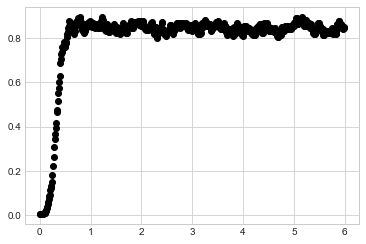

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import numpy as np

plt.plot(check_times, prop_inf, 'o', color='black');
